In [1]:
#Techniques used in this project were learned from Udacity Self-Driving Car program and were adapted to do this project.

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lesson_Functions import *
%matplotlib inline

# Collect data

8968
8792
Your function returned a count of 1001  cars and 1001  non-cars
of size:  (64, 64, 3)  and data type: float32


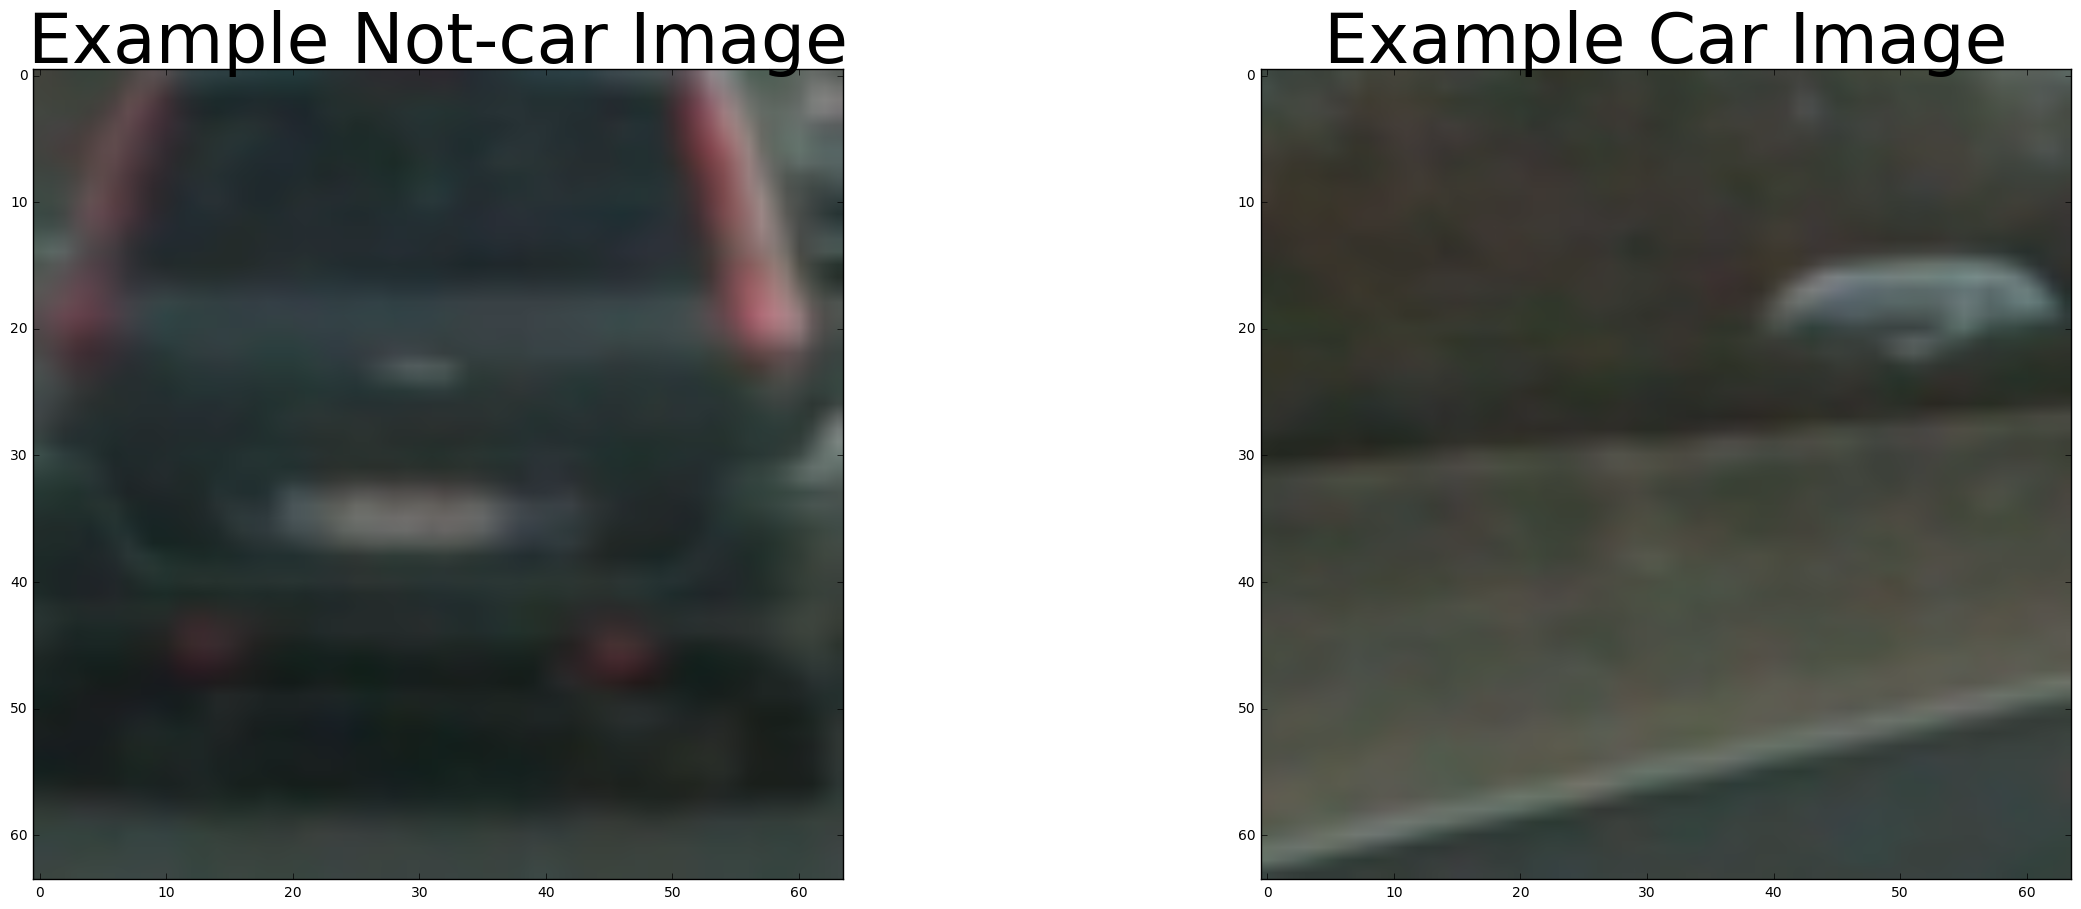

In [3]:
import os.path
import pickle

if not os.path.isfile("images_pickle.p"):
    collect_data() 
    dist_pickle = pickle.load( open("images_pickle.p", "rb" ) )
    cars = dist_pickle["cars"]
    notcars = dist_pickle["notcars"]
else:
    # Load the camera calibration result 
    dist_pickle = pickle.load( open("images_pickle.p", "rb" ) )
    cars = dist_pickle["cars"]
    notcars = dist_pickle["notcars"]

# Build a clasifier

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
def build_clasifier():
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    #Display results
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    # svc = LinearSVC()
    #svc = svm.SVC(decision_function_shape='ovo')
    #svc = svm.SVC(C=10, kernel='linear', degree=3, gamma='auto', coef0=10, shrinking=True, probability=False, tol=0.001, 
    #             cache_size=200, class_weight=None, verbose=True, max_iter=-1, decision_function_shape='ovo', random_state=3)
    svc = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
                cache_size=200, decision_function_shape='ovr', random_state=None)
    #Check the training time for the SVC
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    n_predict = 10
    print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])

    # Save the camera calibration result 
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["cars"] = cars
    dist_pickle["notcars"] = notcars
    pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ))

# Search car

In [5]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0]:box[1], box[2]:box[3]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
        
# Define a single function that can extract features using hog sub-sampling and make predictions
# The code below defines a single function find_cars that's able to both extract features and make predictions.
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, spatial_feat = True, hist_feat = True):
    box = [] 
    box.append(None)
    box.append(None)
    box_list = []
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), 
                                                       np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            file_features = []
           
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            feature_image = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if (spatial_feat):
                spatial_features = bin_spatial(feature_image, size=spatial_size)
                file_features.append(spatial_features)
            if (hist_feat):
                #hist_features = color_hist(subimg, nbins=hist_bins)
                hist_features = color_hist(feature_image, nbins=hist_bins)
                file_features.append(hist_features)
                
            file_features.append(hog_features) 
            
            features = np.concatenate(file_features)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(file_features)
            #test_prediction = svc.predict(test_features)
            
            #scaled_X contains the normalized feature vectors
            test_features = X_scaler.transform(np.array(features).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((ytop_draw+ystart,ytop_draw+win_draw+ystart,xbox_left,xbox_left+win_draw))
                box_list.append(box)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw]+=1
    # Add heat to each box in box list
    # heatmap = add_heat(heatmap, box_list)
    # heatmap = apply_threshold(heatmap, 2)
                
    # Find final boxes from heatmap using label function
    #labels = label(heatmap)
    #draw_label = draw_labeled_bboxes(np.copy(img), labels)
    
    return box_list


# Load data

In [8]:
if not os.path.isfile("svc_pickle.p"):
    build_clasifier()
else:
    # Load the camera calibration result 
    dist_pickle = pickle.load(open("svc_pickle.p", "rb" ))
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]

Feature vector length: 3576
Test Accuracy of SVC =  0.985
My SVC predicts:      [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  1.]


# Parameters

In [9]:
### Parameters
color_space = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

##HOG Parameters
orient = 6               # 9->16                                ++ = -squares
pix_per_cell = 8         # 8->16                                ++ = DECREASES SIZE
cell_per_block = 2       # 5   ->helps with normalizaiton       ++increaes SIZE
hog_channel = "ALL"      # 0 Can be 0, 1, 2, or "ALL"           ++ = +squares

#bin_spatial Parameters  ++increaes SIZE
spatial_size = (16, 16)  # (40, 40)Spatial binning dimensions    ++ = +squares   
hist_bins = 16           # 32      Number of histogram bins      ++ = +squares

#Enable features  
spatial_feat = False     # Spatial features on or off
hist_feat = True         # Histogram features on or off
hog_feat = True          # HOG features on or off
    
xy_overlap=(0.5, 0.5)
#build_clasifier()

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Pipeline

In [14]:
from scipy.ndimage.measurements import label
scales = [1.2, 1.5, 1.8, 2.1]
count = 0 

#initialice list
boxes_list = []
for scale in scales: 
    boxes_list.append(None)

toggle = True
def pipeline(image):
    global count, boxes_list, toggle

    #getIndex   
    if count > len(scales)-1:
        count = 0
    
    if (toggle):
        #identefy size of the screen to work on
        y_start_stop=[int(image.shape[0]/2), image.shape[0]-50]
        boxes = find_cars(image, y_start_stop[0], y_start_stop[1], scales[count], svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                 spatial_feat=spatial_feat, hist_feat = hist_feat)
    
        boxes_list[count]= boxes
        count = count + 1
    else:
        img_label = image
        
    #stack heatmaps
    try:
        #Initilice heatmap
        heatmap = np.zeros_like(image[:,:,0])
        
        # Add heat to each box in box list
        heatmap = add_heat(heatmap, boxes_list[0])
        heatmap = add_heat(heatmap, boxes_list[1])
        heatmap = add_heat(heatmap, boxes_list[2])
        heatmap = add_heat(heatmap, boxes_list[3])

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_boxes = draw_labeled_bboxes(np.copy(image), labels)
    except:
        draw_boxes = image

    toggle = not toggle 
    printImg(img_label, draw_boxes, img1_title = 'Input Image', img2_title = 'Output Image')
    return draw_boxes

# Test images

# Test Video